<a href="https://colab.research.google.com/github/tvml/ml2324/blob/master/codici/gaussian_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09','#c79fef', '#80f9ad']

Consider the (hidden) function 
$$f(x)=\sin\left(\frac{3\pi x}{10}\right)+\cos\left(\frac{7\pi x}{10}\right)$$

In [4]:
#d = 1

def f(x):
    f = np.sin((3*np.pi)*x/10) + np.cos((7*np.pi)*x/10)
    return(f)

In [5]:
X = np.linspace(start=0, stop=10, num=1000)
Y = f(X)

## Generate Data Samples

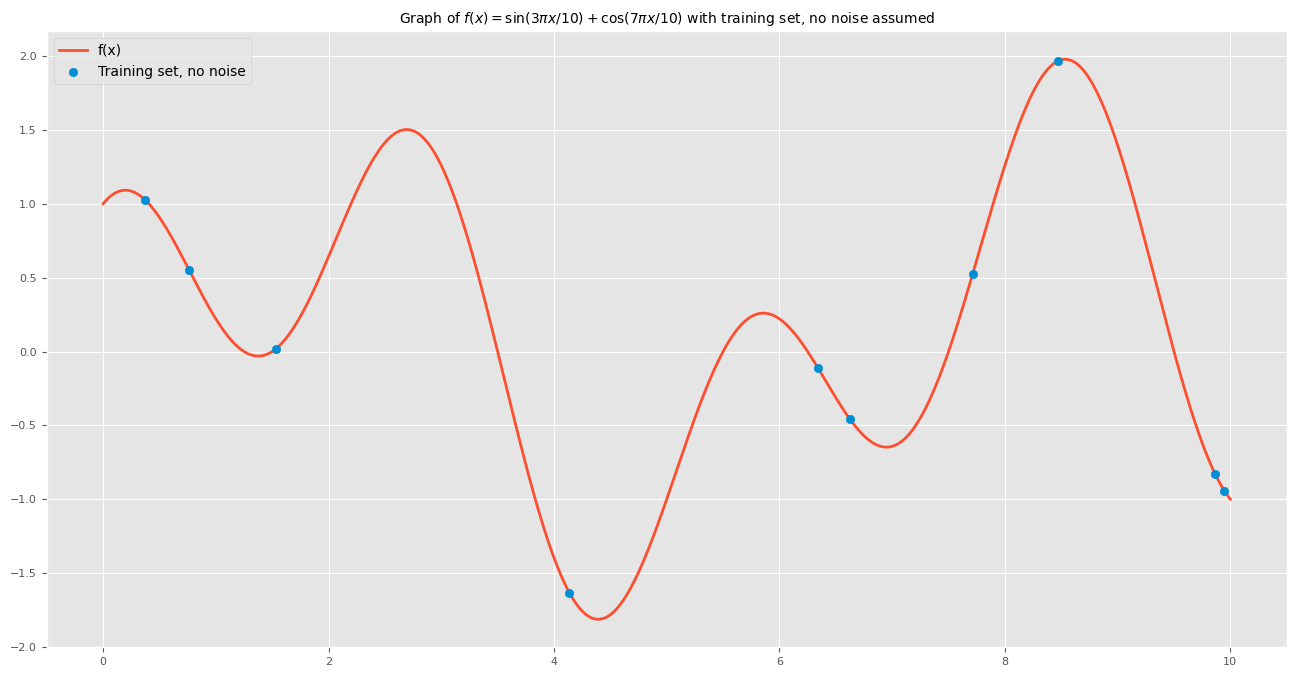

In [6]:
# Number of samples (training set). 
n = 10
x = np.random.rand(n)*10
x = np.sort(x)
t = f(x)

fig, ax = plt.subplots()
plt.plot(X, Y, color=colors[1], label='f(x)', zorder=2)
plt.scatter(x, t, color=colors[0], label='Training set, no noise', zorder=3)

plt.legend(loc='upper left')
plt.title(r'Graph of $f(x) = \sin(3\pi x/10) + \cos(7\pi x/10)$ with training set, no noise assumed');

Next, we generate some training sample observations for the case when a gaussian noise is assumed:

In [7]:
# Error standard deviation. 
sigma_n = 0.2

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Observed target variable. 
t_n = t + epsilon

Let us see the error distribution.

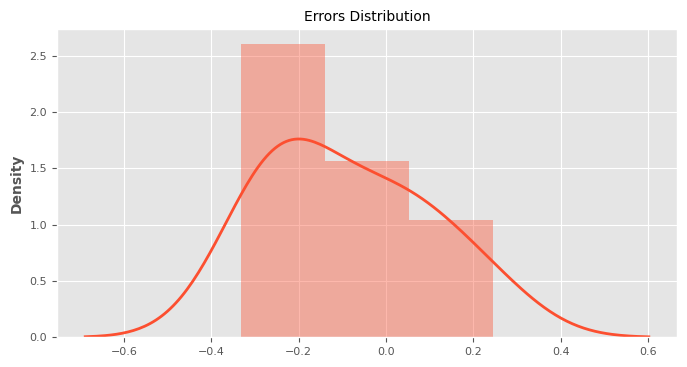

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
# Plot errors. 
sns.distplot(a=epsilon, color=colors[1], ax=ax)
ax.set(title='Errors Distribution');

Let us now visualize the sample data:

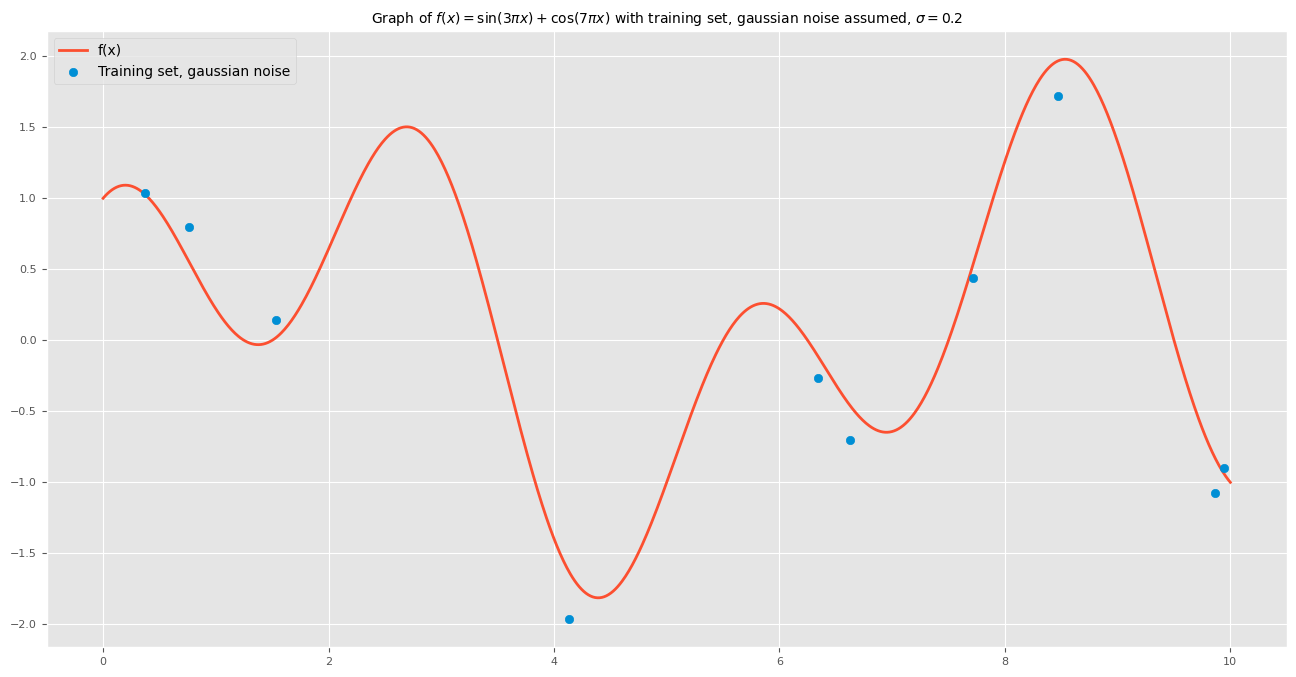

In [9]:
fig, ax = plt.subplots()
plt.plot(X, Y, color=colors[1], label='f(x)', zorder=2)
plt.scatter(x, t_n, color=colors[0], label='Training set, gaussian noise', zorder=3)

plt.legend(loc='upper left')
plt.title(r'Graph of $f(x) = \sin(3\pi x) + \cos(7\pi x)$ with training set, gaussian noise assumed, $\sigma={}$'.format(sigma_n));

We now consider test data points on which we want to generate predictions.

In [10]:
#n_star = 1000
#x_star = np.sort(np.random.rand(n_star))
x_star = X

## Kernel Function

A gaussian process is completely specified by its mean and covariance functions $m(x), \kappa(x,x')$. Usually, it is assumed $m(x)=0$, while a common choice for $\kappa(x,x')$ is the *squared exponential*, 

$$
\text{cov}(f(x_p), f(x_q)) = \kappa_{\sigma_f, \ell}(x_p, x_q) = \sigma_f \exp\left(-\frac{\lVert x_p - x_q\rVert^2}{2\ell^2} \right)
$$

where $\sigma_f , \ell >0$ are hyperparameters.

In [11]:
def kernel_function(x, y, sigma_f=1, l=1):
    return sigma_f*np.exp(-(np.linalg.norm(x-y)**2)/(2*l**2))

Let us select the parameters:

In [12]:
l = .8
sigma_f = 1

## Compute Covariance Matrices

Let us denote by $K(X, X) \in M_{n}(\mathbb{R})$, $K(X_*, X) \in M_{n_* \times n}(\mathbb{R})$ and $K(X_*, X_*) \in M_{n_*}(\mathbb{R})$ the covariance matrices applies to $x$ and  $x_*$. 

In [13]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=1, l=1, noise=True, sigma_n=0.1):
    """
    Compute the components of the covariance matrix of the joint distribution
    for Gaussian Process regression.
    
    This function builds the covariance matrices between training points (X),
    test points (X*), and their cross-covariance. The joint distribution is:
    
        [y    ]  ~  N(0, [ K      k_star.T ])
        [y*   ]         [ k_star  K_star   ]
    
    Notation:
        - K = K(X, X)           : covariance matrix between training points
        - K_star = K(X*, X*)    : covariance matrix between test points
        - k_star = K(X*, X)     : cross-covariance between test and training points
    
    Args:
        x (array-like):         Training input points, shape (n,) or (n, d)
        x_star (array-like):    Test input points, shape (n_star,) or (n_star, d)
        sigma_f (float):        Signal variance parameter of the kernel (default: 1)
        l (float):              Length scale parameter of the kernel (default: 1)
        noise (bool):           Whether to add observational noise to K (default: True)
        sigma_n (float):        Noise standard deviation (default: 0.1)
        
    Returns:
        tuple: (C, K, K_star, k_star)
            - C:        Joint covariance matrix combining all components
            - K:        Covariance matrix of training points
            - K_star:   Covariance matrix of test points
            - k_star:   Cross-covariance matrix
    """
    
    # Get the number of training and test points
    n = x.shape[0]
    n_star = x_star.shape[0]
    
    # ========================================================================
    # COMPUTE K: Covariance matrix between training points (n x n)
    # ========================================================================
    # itertools.product(x, x) generates all pairs (i, j) from x
    # For each pair, compute the kernel function value
    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) 
         for (i, j) in itertools.product(x, x)]
    
    # Flatten the list into a 1D array and reshape to matrix form
    K = np.array(K).reshape(n, n)
    
    
    # ========================================================================
    # COMPUTE K_star: Covariance matrix between test points (n_star x n_star)
    # ========================================================================
    # Same process as K, but for test points
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) 
              for (i, j) in itertools.product(x_star, x_star)]
    
    # Flatten and reshape to matrix form
    K_star = np.array(K_star).reshape(n_star, n_star)
    
    
    # ========================================================================
    # COMPUTE k_star: Cross-covariance between test and training points
    # ========================================================================
    # Generate all pairs (i, j) where i is from test points and j is from training points
    # This gives us the covariance between predictions and observations
    k_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) 
              for (i, j) in itertools.product(x_star, x)]
    
    # Flatten and reshape to matrix form (n_star x n)
    k_star = np.array(k_star).reshape(n_star, n)
    
    
    # ========================================================================
    # ADD OBSERVATIONAL NOISE (optional)
    # ========================================================================
    # If noise=True, add Gaussian observational noise to the diagonal of K
    # This represents measurement uncertainty in the training data
    # The noise term is (sigma_n^2) * I, where I is the identity matrix
    if noise:
        K = K + (sigma_n**2) * np.eye(n)
    
    
    # ========================================================================
    # ASSEMBLE THE JOINT COVARIANCE MATRIX C
    # ========================================================================
    # The joint covariance matrix has the block structure:
    #
    #     C = [ K        k_star.T ]
    #         [ k_star   K_star   ]
    #
    # This is built in two steps:
    # 1. Stack vertically: top part [K, k_star.T] and bottom part [k_star, K_star]
    # 2. Then concatenate horizontally
    
    # Build the top half: [K | k_star.T]
    # axis=1 means concatenate horizontally (column-wise)
    a = np.concatenate((K, k_star.T), axis=1)
    
    # Build the bottom half: [k_star | K_star]
    # k_star.T is the transpose (n x n_star) to match the dimensions
    b = np.concatenate((k_star, K_star), axis=1)
    
    # Stack the two halves vertically to form the complete joint matrix
    # axis=0 means concatenate vertically (row-wise)
    C = np.concatenate((a, b), axis=0)
    
    
    # ========================================================================
    # RETURN RESULTS
    # ========================================================================
    # Return all computed matrices:
    # - C is the full joint covariance matrix, needed for predictions
    # - K, K_star, k_star are returned for potential reuse or inspection
    return (C, K, K_star, k_star)

## No noise assumption

We assume the observed values $t=(t_1,\ldots,t_n)^T$ in correspondance to the training set items $X=(x_1,\ldots,x_n)^T$ are precisely the values $$f=(f(x_1),\ldots,f(x_n))^T$$ 

In this case, given the set of test points $X^*=(x^*_1,\ldots,x^*_m)^T$ the joint distribution of $f$ and $f^*=(f(x_1^*),\ldots,f(x_m^*))^T$ is given by 

$$
\left(
\begin{array}{c}
f \\
f_*
\end{array}
\right)
\sim
\mathcal{N}(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X) & k(X, X^*) \\
k(X, X^*)^T & K(X^*)
\end{array}
\right)
$$
and

- $K(X)_{ij} = \kappa(x_i,x_j)$, with $i,j =1,\ldots, n$ 
- $k(X,X^*)_{ij} = \kappa(x_i,x^*_j)$, with $i=1,\ldots, n$  and $j=1,\ldots, m$
- $K(X^*)_{ij} = \kappa(x^*_i,x^*_j)$, with $i,j =1,\ldots, m$ 

Let us compute the components:

In [14]:
C_n, K_n, K_star_n, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=False)

Let us consider each component:

$K(X)$

In [15]:
print(f'Shape: {K_n.shape}')

Shape: (10, 10)


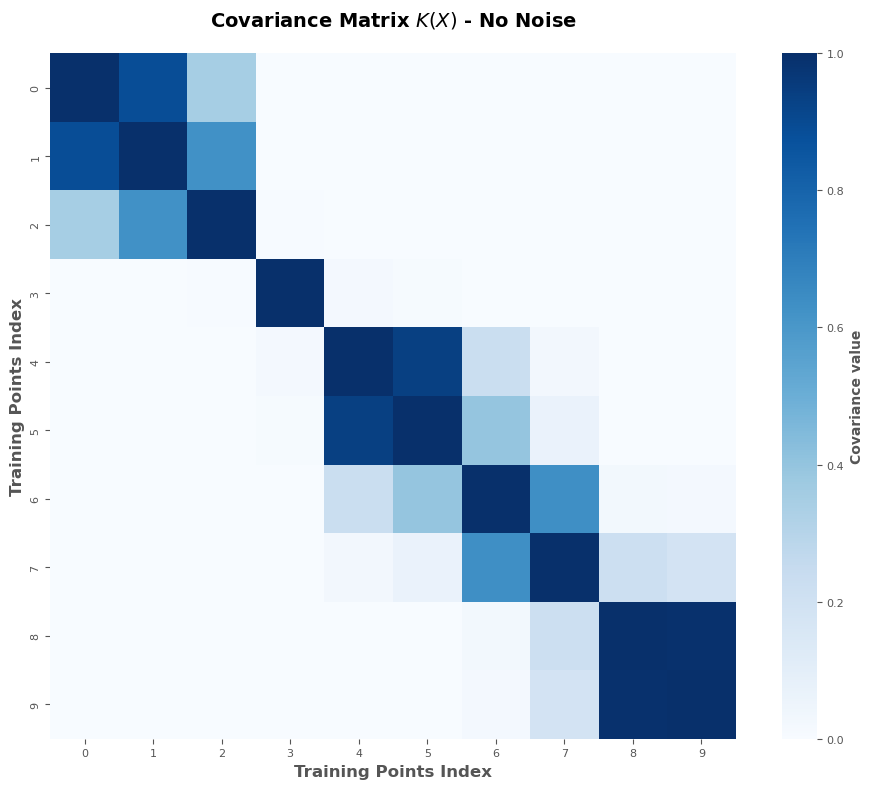

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    data=K_n,
    cmap='Blues',
    ax=ax,
    cbar_kws={'label': 'Covariance value'},  # Add label to colorbar
    square=True,  # Make cells square for better visual proportion
    annot=False  # Set to True if matrix is small and you want to see values
)

ax.set_title('Covariance Matrix $K(X)$ - No Noise', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Training Points Index', fontsize=12)
ax.set_ylabel('Training Points Index', fontsize=12)

plt.tight_layout()
plt.show()

$K(X_*)$

In [18]:
print(f'Shape: {K_star_n.shape}')

Shape: (1000, 1000)


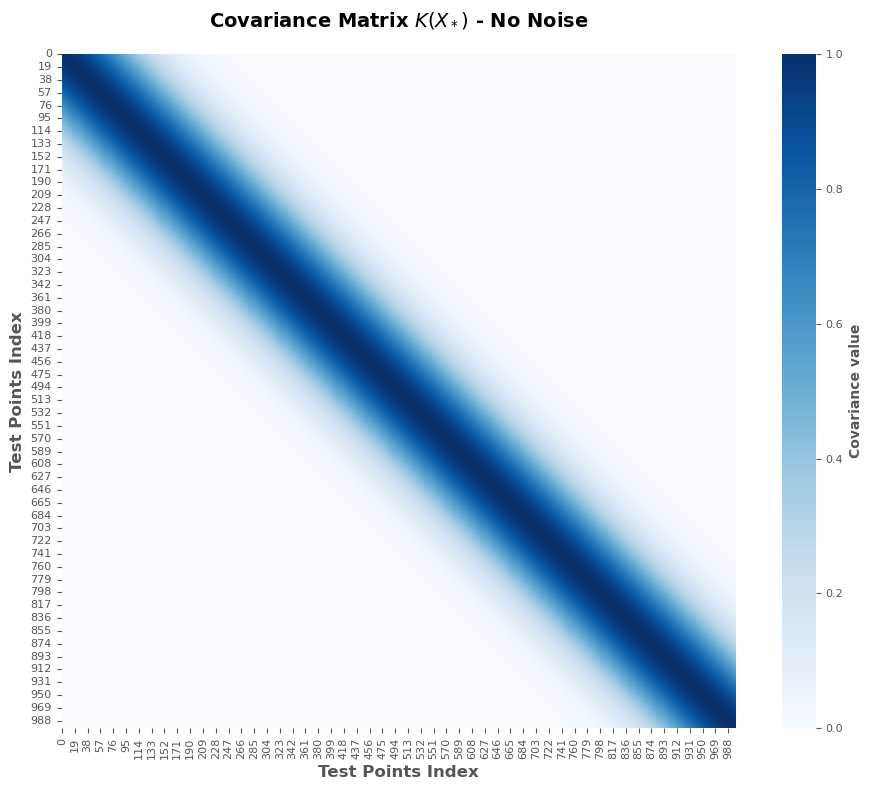

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    data=K_star_n,
    cmap='Blues',
    ax=ax,
    cbar_kws={'label': 'Covariance value'},  # Add label to colorbar
    square=True,  # Make cells square for better visual proportion
    annot=False  # Set to True if matrix is small and you want to see values
)

ax.set_title('Covariance Matrix $K(X_*)$ - No Noise', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Test Points Index', fontsize=12)
ax.set_ylabel('Test Points Index', fontsize=12)

plt.tight_layout()
plt.show()

$k(X_*,X)$

In [21]:
print(f'Shape: {k_star.shape}')

Shape: (1000, 10)


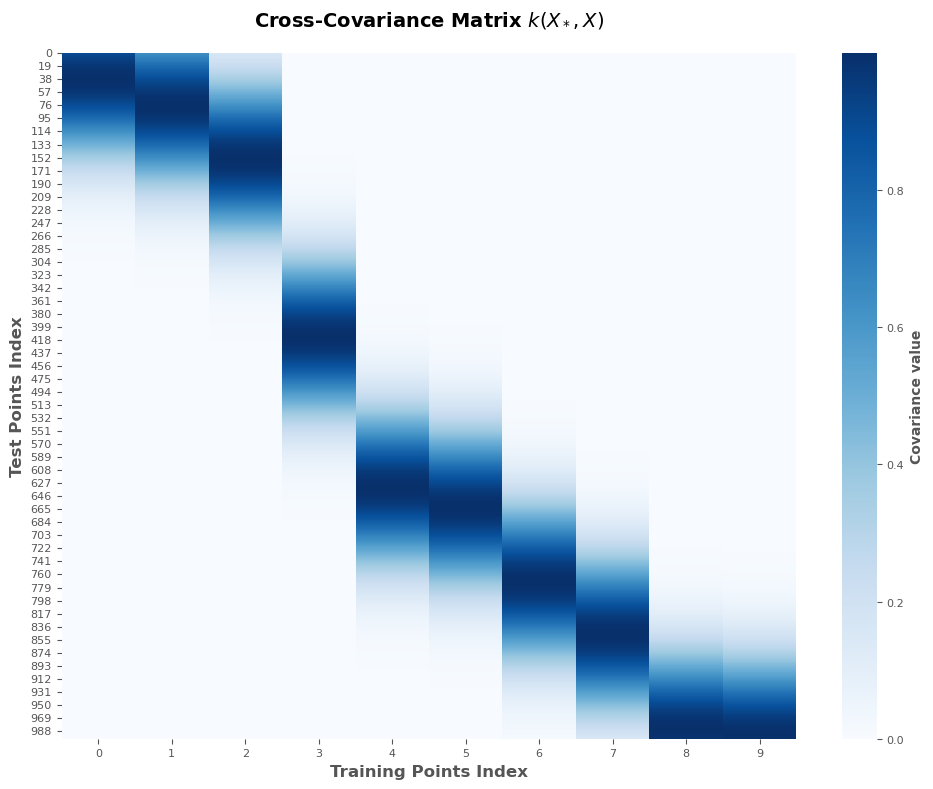

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    data=k_star,
    cmap='Blues',
    ax=ax,
    cbar_kws={'label': 'Covariance value'},  # Add label to colorbar
    annot=False  # Set to True if matrix is small and you want to see values
)

ax.set_title('Cross-Covariance Matrix $k(X_*, X)$', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Training Points Index', fontsize=12)
ax.set_ylabel('Test Points Index', fontsize=12)

plt.tight_layout()
plt.show()


The covariance matrix $C_n$

In [26]:
print(f'Shape: {C_n.shape}')

Shape: (1010, 1010)


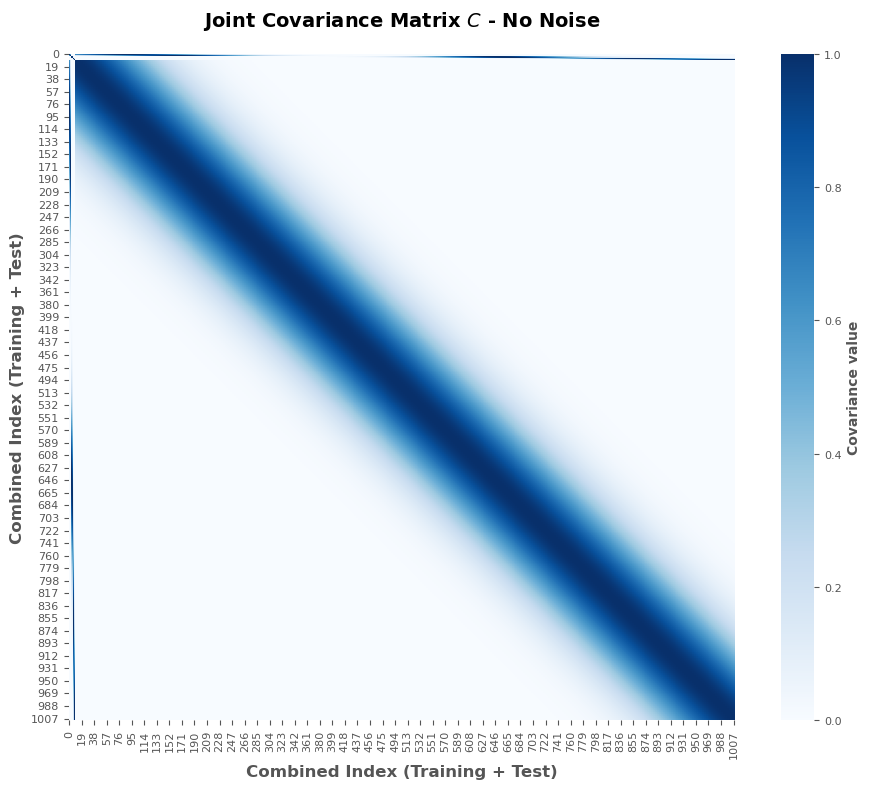

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    data=C_n,
    cmap='Blues',
    ax=ax,
    cbar_kws={'label': 'Covariance value'},  # Add label to colorbar
    square=True,  # Make cells square
    annot=False  # Set to True if matrix is small and you want to see values
)

ax.set_title('Joint Covariance Matrix $C$ - No Noise', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Combined Index (Training + Test)', fontsize=12)
ax.set_ylabel('Combined Index (Training + Test)', fontsize=12)

plt.tight_layout()
plt.show()

The prior distribution for $f^*$ is $N(\mu, \Sigma)$, with $\mu=0$ and $\Sigma=K(X^*)$

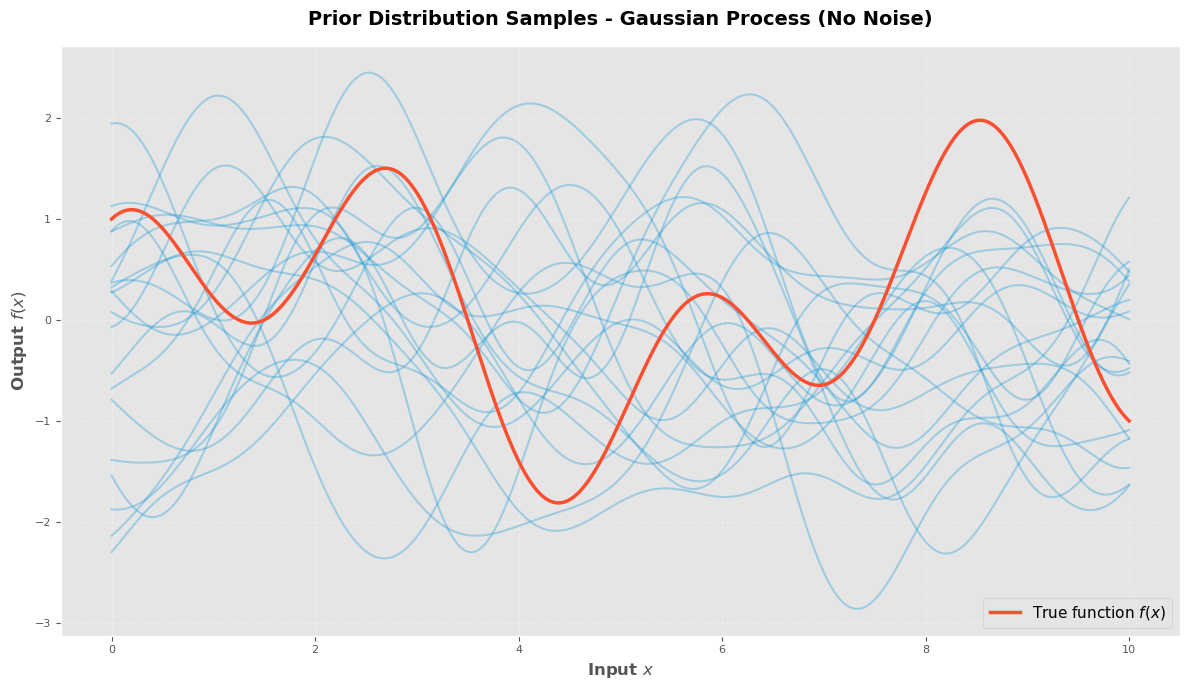

In [29]:
fig, ax = plt.subplots(figsize=(12, 7))

# Initialize mean vector for the prior (zero mean GP)
mean_z = np.zeros_like(X)

# Number of function samples to draw from the prior
n_samples = 20

# Sample from the prior distribution and plot each sample
for i in range(n_samples):
    # Sample a function from the prior: z ~ N(0, K_star)
    # K_star is the covariance matrix of the test points
    z_star = np.random.multivariate_normal(mean=mean_z, cov=K_star_n)
    
    # Plot the sampled function with transparency to show overlapping samples
    ax.plot(X, z_star, color=colors[0], alpha=0.3, linewidth=1.5)

# Plot the true underlying function
ax.plot(X, Y, color=colors[1], linewidth=2.5, label='True function $f(x)$', zorder=10)

# Configure plot appearance
ax.set_title('Prior Distribution Samples - Gaussian Process (No Noise)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Input $x$', fontsize=12)
ax.set_ylabel('Output $f(x)$', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()

In [30]:
def compute_gpr_parameters(K, K_star, k_star, y):
    """
    Compute the posterior mean and covariance of a Gaussian Process regression.
    
    This function implements the standard GP regression equations to compute
    predictions at test points given training observations.
    
    Posterior distribution: p(f_* | X, y, X_*) = N(f_bar_*, cov_f_*)
    
    Args:
        K (np.ndarray):         Covariance matrix of training points, shape (n, n)
                                K = k(X, X) where X are training inputs
                                
        K_star (np.ndarray):    Covariance matrix of test points, shape (n_*, n_*)
                                K_* = k(X_*, X_*) where X_* are test inputs
                                
        k_star (np.ndarray):    Cross-covariance between test and training points, shape (n_*, n)
                                k_* = k(X_*, X) between test and training inputs
                                
        y (np.ndarray):         Observed training outputs, shape (n,) or (n, d)
                                The training data we're conditioning on
    
    Returns:
        tuple: (f_bar_star, cov_f_star)
            - f_bar_star:       Posterior mean at test points, shape (n_*, ) or (n_*, d)
                                The predicted function values
                                
            - cov_f_star:       Posterior covariance at test points, shape (n_*, n_*)
                                Represents uncertainty in predictions
    
    Mathematical Background:
    ========================
    
    Given training data (X, y) and test inputs X_*, the GP posterior is:
    
        f_* | X, y, X_* ~ N(μ_*, Σ_*)
    
    Where:
        μ_* = k_*^T K^(-1) y          (Posterior mean)
        Σ_* = K_* - k_*^T K^(-1) k_*  (Posterior covariance)
    
    Intuition:
    ----------
    
    1. POSTERIOR MEAN: μ_* = k_*^T K^(-1) y
       - Predicts test outputs as a weighted combination of training outputs
       - Weights are determined by covariance structure (closer points get higher weight)
       - K^(-1) y solves the system K α = y for α (equivalent to regression coefficients)
    
    2. POSTERIOR COVARIANCE: Σ_* = K_* - k_*^T K^(-1) k_*
       - First term K_* is the prior uncertainty at test points
       - Second term k_*^T K^(-1) k_* represents uncertainty reduction from observations
       - The more we observe near a test point, the smaller this term becomes
       - At training points where k_* K^(-1) k_* ≈ K, covariance → 0 (high certainty)
    """
    
    # ========================================================================
    # EXTRACT DIMENSIONS
    # ========================================================================
    n = K.shape[0]  # Number of training points
    # Note: y.reshape([n, d]) assumes y might be multi-dimensional output
    # but typically for 1D regression, d=1
    
    
    # ========================================================================
    # COMPUTE INVERSE OF K
    # ========================================================================
    # K_inv = K^(-1)
    # This is one of the most computationally expensive operations
    # For large n (e.g., n > 10,000), this becomes problematic
    # In practice, one would use Cholesky decomposition or other efficient methods
    K_inv = np.linalg.inv(K)
    
    
    # ========================================================================
    # COMPUTE POSTERIOR MEAN: f̄_* = k_*^T K^(-1) y
    # ========================================================================
    # 
    # Step-by-step breakdown:
    # 1. K_inv @ y                computes the solution α = K^(-1) y
    #    This is equivalent to solving K α = y
    #    α contains the "influence coefficients" for each training point
    #
    # 2. k_star @ (K_inv @ y)     computes the predicted means at test points
    #    Each test point is predicted as a weighted sum of training outputs
    #    weights = k_star @ K_inv
    #    prediction = weights @ y
    #
    # Shape tracking:
    #   k_star:           (n_*, n)     test-training cross-covariance
    #   K_inv:            (n, n)       inverse of training covariance
    #   y:                (n, d)       training outputs (reshaped)
    #   K_inv @ y:        (n, d)
    #   k_star @ (K_inv @ y): (n_*, d) posterior mean at test points
    
    f_bar_star = np.dot(k_star, np.dot(K_inv, y.reshape([n, 1])))
    
    
    # ========================================================================
    # COMPUTE POSTERIOR COVARIANCE: Σ_* = K_* - k_*^T K^(-1) k_*
    # ========================================================================
    #
    # This represents the posterior uncertainty (predictive variance) at test points.
    #
    # Interpretation of the two terms:
    #
    # 1. K_* (Prior term):
    #    The covariance of the prior distribution at test points.
    #    Represents the uncertainty we have BEFORE observing any data.
    #    This term is always positive definite (due to kernel properties).
    #
    # 2. k_*^T K^(-1) k_* (Information gain term):
    #    Represents how much uncertainty is REDUCED by observing training data.
    #    The more training points near a test point, the larger this term.
    #    At exact training points, this term equals K_*, so uncertainty → 0.
    #
    # Special properties:
    #    - Both K_* and k_*^T K^(-1) k_* are positive semidefinite
    #    - Their difference is positive semidefinite (ensures valid covariance)
    #    - Diagonal elements represent marginal variances (uncertainty per point)
    #    - Off-diagonal elements represent correlations between predictions
    #
    # Shape tracking:
    #   K_star:                    (n_*, n_*)      prior covariance at test points
    #   k_star:                    (n_*, n)        cross-covariance
    #   K_inv:                     (n, n)          inverse training covariance
    #   k_star.T:                  (n, n_*)        transpose of cross-covariance
    #   k_star @ K_inv:            (n_*, n)
    #   (k_star @ K_inv) @ k_star.T: (n_*, n_*)   information gain (uncertainty reduction)
    #   K_* - (...):               (n_*, n_*)      posterior covariance
    
    cov_f_star = K_star - np.dot(k_star, np.dot(K_inv, k_star.T))
    
    
    # ========================================================================
    # RETURN RESULTS
    # ========================================================================
    # Returns both the posterior mean and covariance
    # These define the complete posterior distribution: N(f_bar_star, cov_f_star)
    return (f_bar_star, cov_f_star)

In [31]:
m, c = compute_gpr_parameters(K_n, K_star_n, k_star, t)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

# Number of posterior samples to draw
n_posterior_samples = 20

# Draw samples from the posterior distribution
# Given: mean (m) and covariance (c) from GP conditioning on observations
for i in range(n_posterior_samples):
    # Sample a function from the posterior distribution
    # These samples are consistent with both the kernel assumptions AND the observed training data
    z_star = np.random.multivariate_normal(mean=m.ravel(), cov=c)
    
    # Plot each posterior sample with transparency to show density
    ax.plot(X, z_star, color=colors[0], alpha=0.3, linewidth=1.5, label='Posterior samples' if i == 0 else '')

# Plot the training observations (the data we conditioned on)
ax.scatter(x, t, color=colors[7], s=100, marker='o', edgecolors='black', 
          linewidth=1.5, label='Training observations', zorder=10, alpha=0.8)

# Plot the true underlying function
ax.plot(X, Y, color=colors[1], linewidth=2.5, label='True function $f(x)$', zorder=9)

# Configure plot appearance
ax.set_title('Posterior Distribution Samples - Gaussian Process (No Noise)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Input $x$', fontsize=12)
ax.set_ylabel('Output $f(x)$', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()


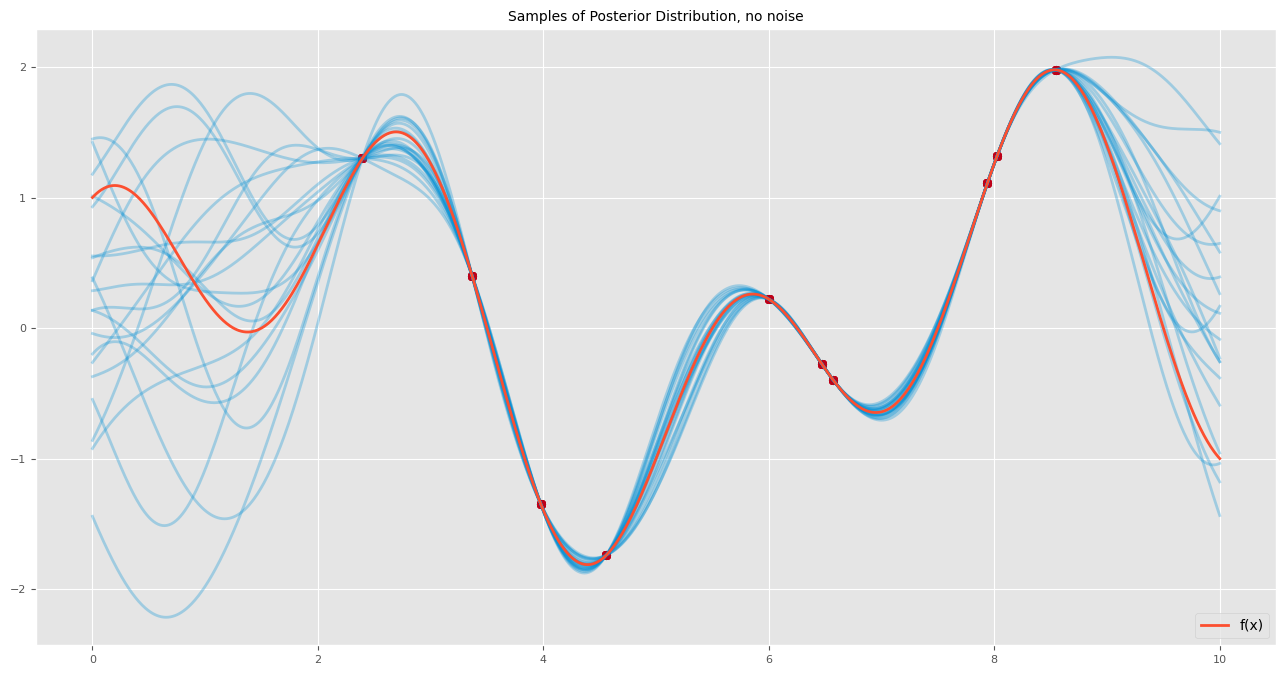

In [30]:
fig, ax = plt.subplots()
for i in range(0, 20):
    # Sample from joint distribution. 
    z_star = np.random.multivariate_normal(mean=m.ravel(), cov=c)
    # Plot function.
    plt.plot(X, z_star, color=colors[0], alpha=0.3)
    plt.scatter(x,t, color=colors[7])
    
# Plot "true" linear fit.
plt.plot(X, Y, color=colors[1], label='f(x)')
ax.set(title='Samples of Posterior Distribution, no noise')
ax.legend(loc='lower right');

In [36]:
def predict(x, X_train, t_train, noise=False):
    C, K, K_star, k_star = compute_cov_matrices(X_train, np.array([x]), l=l, sigma_n=sigma_n, sigma_f= sigma_f, noise=noise)
    m, c = compute_gpr_parameters(K, K_star, k_star, t_train)
    return m.item(),c.item()

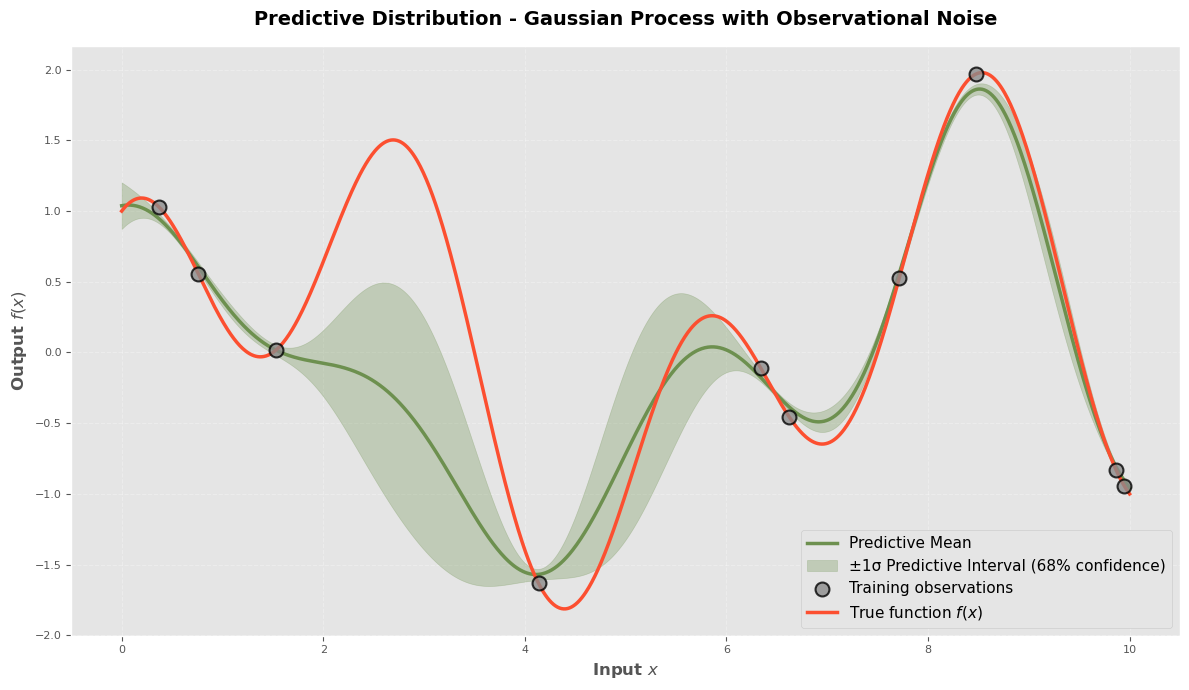

In [37]:

fig, ax = plt.subplots(figsize=(12, 7))

# ========================================================================
# COMPUTE PREDICTIONS FOR ALL TEST POINTS
# ========================================================================
# predict() function returns tuple: (mean, std_dev) for each test point
# when noise=True, includes observational noise in uncertainty estimate
#
# Loop structure: for each test point z in X, compute predictive mean and variance
# z_star shape: (len(X), 2) where columns are [mean, std_dev]
z_star = np.array([predict(z, x, t, noise=True) for z in X])

# Extract mean and standard deviation predictions
mean_predictions = z_star[:, 0]      # shape (len(X),)
std_predictions = z_star[:, 1]       # shape (len(X),)

# ========================================================================
# PLOT PREDICTIVE MEAN
# ========================================================================
# The posterior mean prediction at each test point
ax.plot(X, mean_predictions, color=colors[3], linewidth=2.5, 
        label='Predictive Mean', zorder=8)

# ========================================================================
# PLOT CONFIDENCE/CREDIBLE INTERVAL
# ========================================================================
# Represents 68% confidence interval (±1σ) from predictive distribution
# This includes:
#   1. Posterior function uncertainty (how uncertain about f(x))
#   2. Observational noise (measurement uncertainty, noise=True)
#
# The fill_between creates a shaded region showing the range of plausible values
ax.fill_between(X, 
                mean_predictions - std_predictions,      # lower bound (mean - 1σ)
                mean_predictions + std_predictions,      # upper bound (mean + 1σ)
                color=colors[3], alpha=0.3, 
                label='±1σ Predictive Interval (68% confidence)', zorder=5)

# Optional: Add 95% confidence interval (±2σ) for comparison
# Uncomment the following lines:
# ax.fill_between(X,
#                 mean_predictions - 2*std_predictions,
#                 mean_predictions + 2*std_predictions,
#                 color=colors[3], alpha=0.15,
#                 label='±2σ Predictive Interval (95% confidence)', zorder=4)

# ========================================================================
# PLOT TRAINING OBSERVATIONS
# ========================================================================
# The actual data points we conditioned on
# These should be near the predictive mean with uncertainty roughly matching std_dev
ax.scatter(x, t, color=colors[4], s=100, marker='o', 
          edgecolors='black', linewidth=1.5, 
          label='Training observations', zorder=10, alpha=0.8)

# ========================================================================
# PLOT TRUE UNDERLYING FUNCTION
# ========================================================================
# Reference: the true function we're trying to approximate
# Note: In real applications, we don't have access to this!
ax.plot(X, Y, color=colors[1], linewidth=2.5, 
        label='True function $f(x)$', zorder=9)

# ========================================================================
# CONFIGURE PLOT APPEARANCE
# ========================================================================
ax.set_title('Predictive Distribution - Gaussian Process with Observational Noise', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Input $x$', fontsize=12)
ax.set_ylabel('Output $f(x)$', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()

## Gaussian noise assumption

The joint distribution  of $y$ and $f_*$ is given by 

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
N(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
$$

Observe that we need to add the term $\sigma^2_n I$ to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise). We now compute the matrix $C$.

In [38]:
C_g, K_g, K_star_g, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, sigma_n=sigma_n, l=l, noise=True)

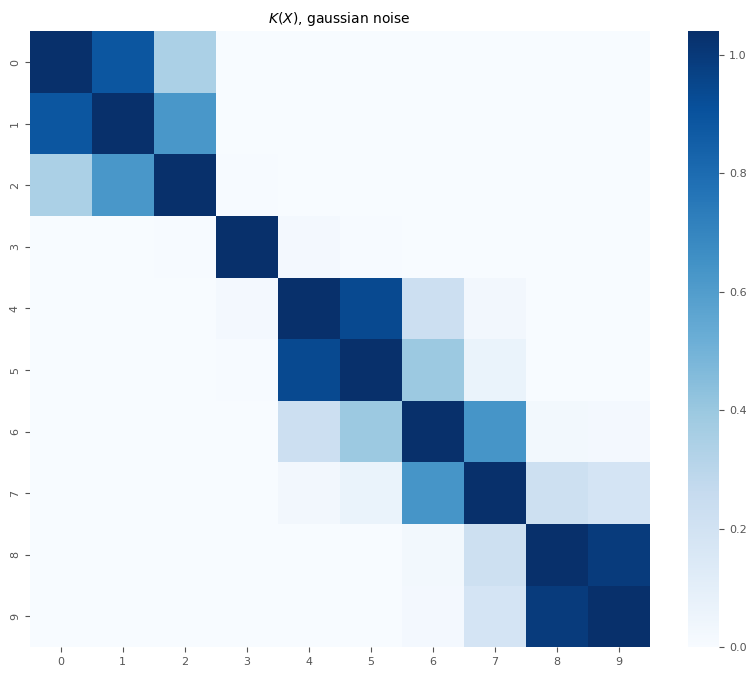

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_g, cmap='Blues', ax=ax)
plt.title('$K(X)$, gaussian noise');

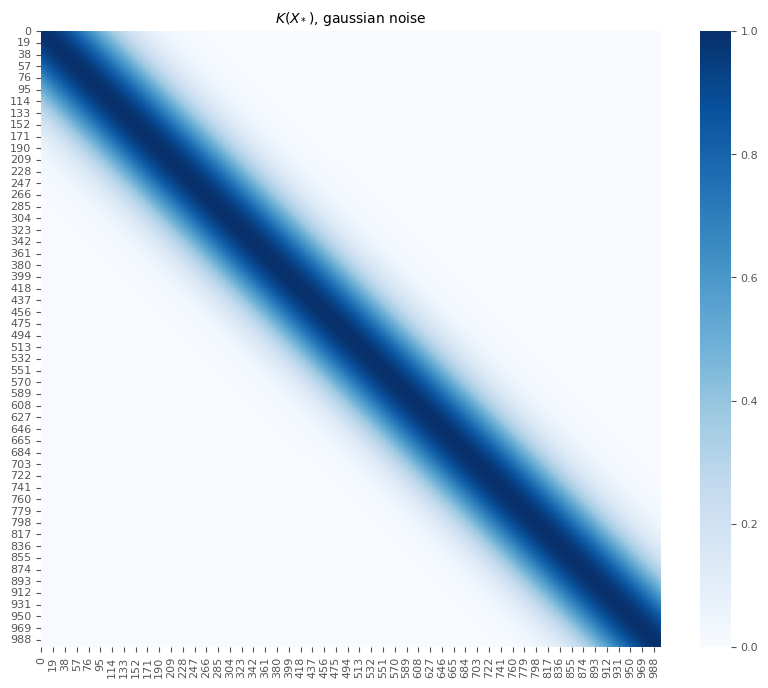

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star_g, cmap='Blues', ax=ax)
plt.title('$K(X_*)$, gaussian noise');

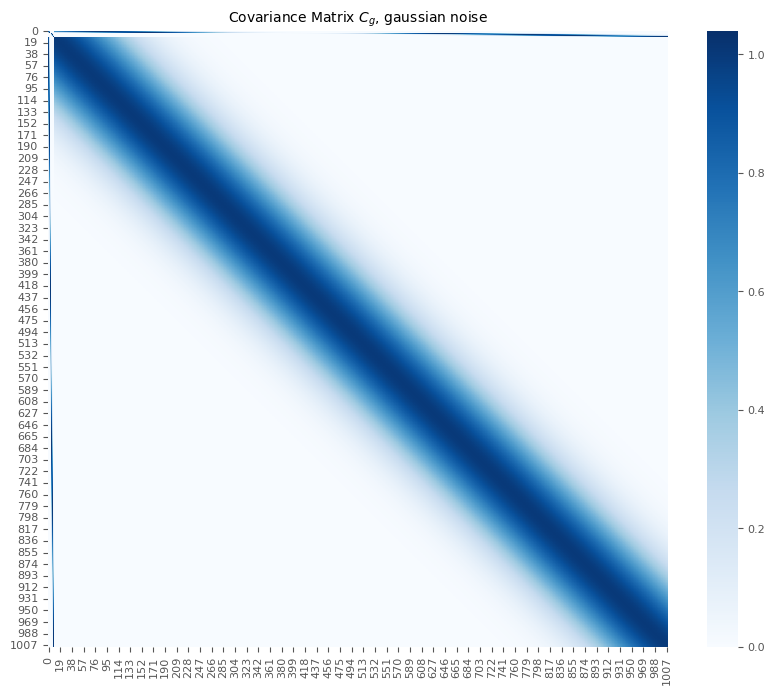

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=C_g, cmap='Blues', ax=ax)
plt.title('Covariance Matrix $C_g$, gaussian noise');

## Prior Distribution 

The prior distribution for $f_*$ is $N(\mu, \Sigma)$, with $\mu=0$ and $\Sigma$ defined by $\kappa(x,x')$. Let us visualize some sample functions from this prior:

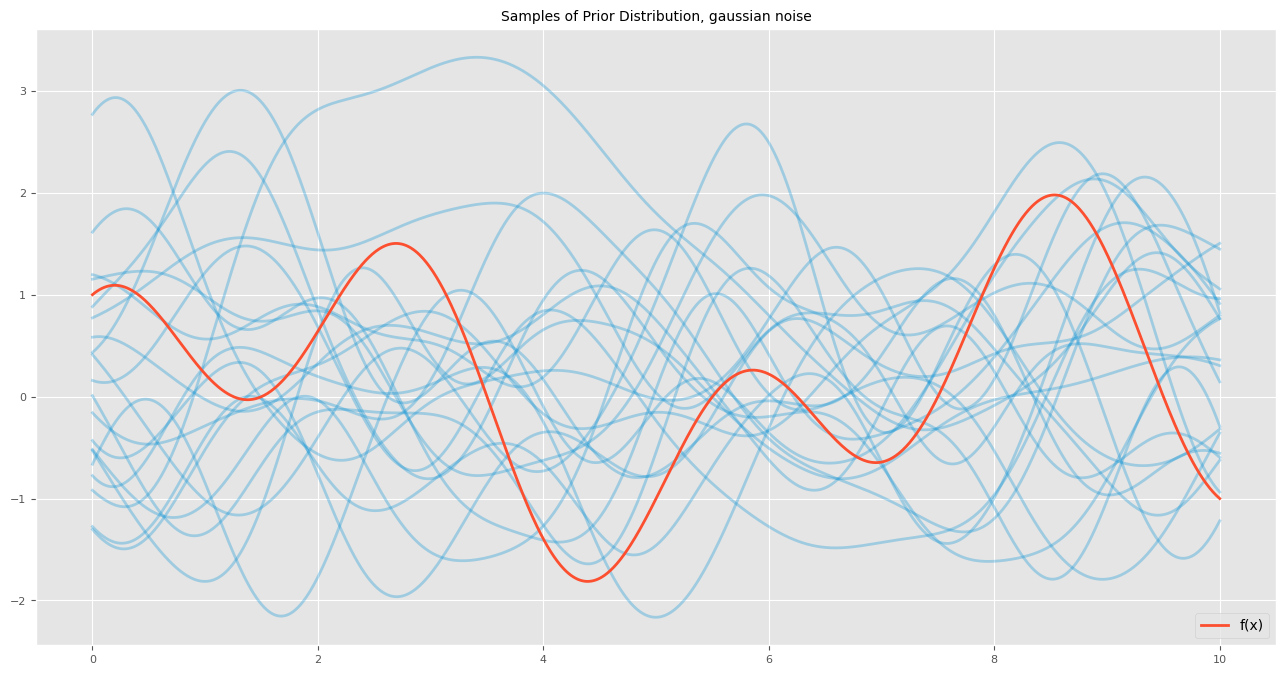

In [37]:
fig, ax = plt.subplots()
mean_z = np.zeros_like(X)
for i in range(0, 20):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=mean_z, cov=K_star_g)
    # Plot function.
    plt.plot(X, z_star, color=colors[0], alpha=0.3)
plt.plot(X, Y, color=colors[1], label='f(x)')
ax.set(title='Samples of Prior Distribution, gaussian noise')
ax.legend(loc='lower right');

In [42]:
m_g, c_g = compute_gpr_parameters(K_g, K_star_g, k_star, t)

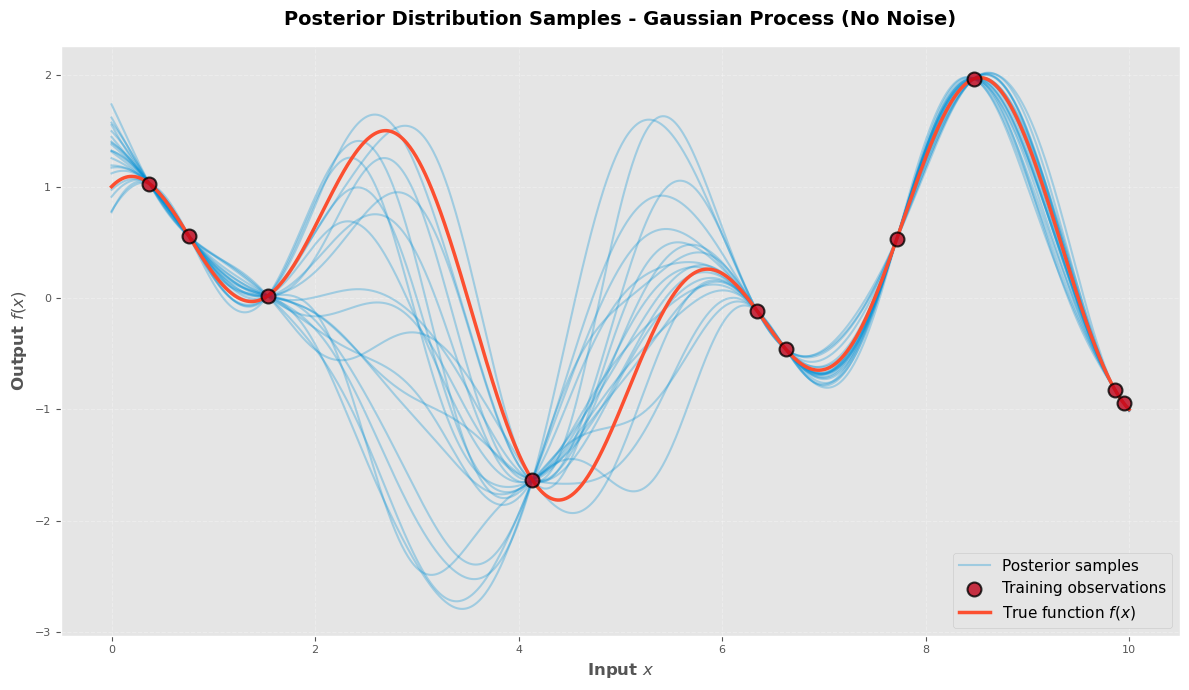

In [43]:
fig, ax = plt.subplots(figsize=(12, 7))

# Number of posterior samples to draw
n_posterior_samples = 20

# Draw samples from the posterior distribution
# Given: mean (m) and covariance (c) from GP conditioning on observations
for i in range(n_posterior_samples):
    # Sample a function from the posterior distribution
    # These samples are consistent with both the kernel assumptions AND the observed training data
    z_star = np.random.multivariate_normal(mean=m.ravel(), cov=c)
    
    # Plot each posterior sample with transparency to show density
    ax.plot(X, z_star, color=colors[0], alpha=0.3, linewidth=1.5, label='Posterior samples' if i == 0 else '')

# Plot the training observations (the data we conditioned on)
ax.scatter(x, t, color=colors[7], s=100, marker='o', edgecolors='black', 
          linewidth=1.5, label='Training observations', zorder=10, alpha=0.8)

# Plot the true underlying function
ax.plot(X, Y, color=colors[1], linewidth=2.5, label='True function $f(x)$', zorder=9)

# Configure plot appearance
ax.set_title('Posterior Distribution Samples - Gaussian Process (No Noise)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Input $x$', fontsize=12)
ax.set_ylabel('Output $f(x)$', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()

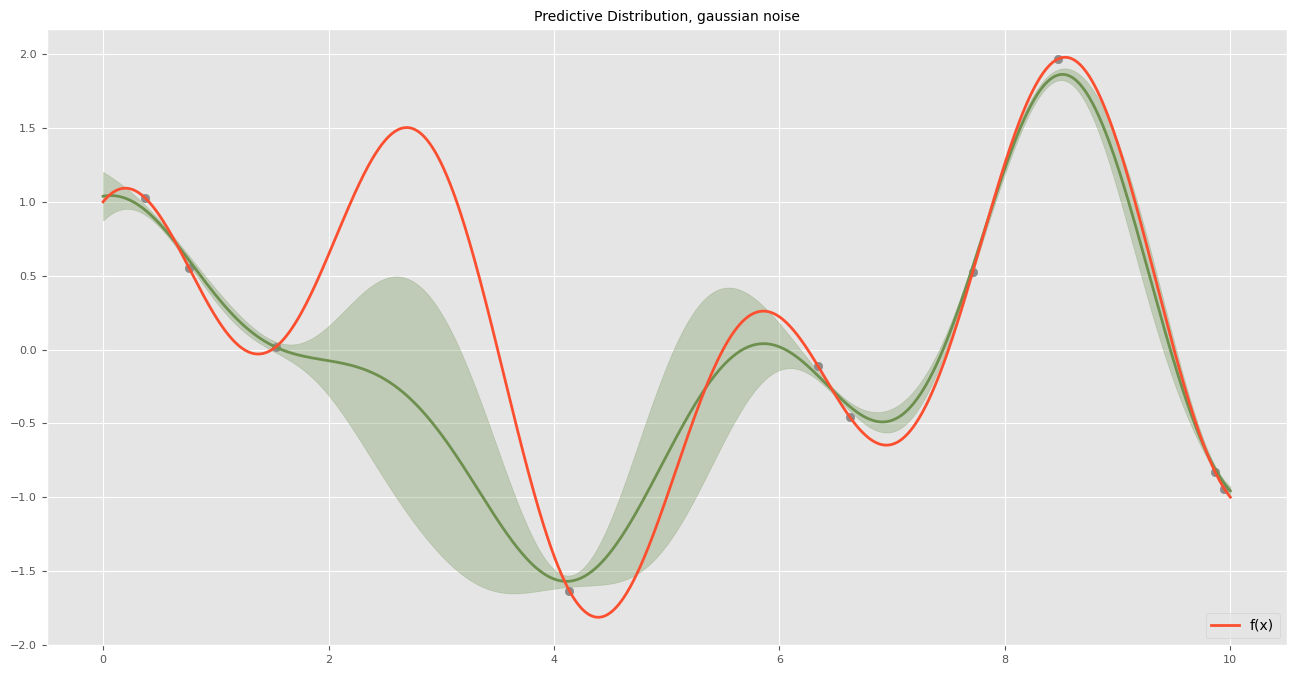

In [45]:
fig, ax = plt.subplots()
z_star = np.array([predict(z, x, t, noise=True) for z in X])

plt.plot(X, z_star[:,0], color=colors[3])
plt.fill_between(X, z_star[:,0]-z_star[:,1], z_star[:,0]+z_star[:,1], color=colors[3], alpha=.3)
plt.scatter(x,t, color=colors[4])
    
# Plot "true" linear fit.
plt.plot(X, Y, color=colors[1], label='f(x)')
ax.set(title='Predictive Distribution, gaussian noise')
ax.legend(loc='lower right');

## Hyperparameters

We now study the effect of the hyperparameters $\sigma_f$ and $\ell$ of the kernel function defined above. 

- The hyperparameter $\sigma_f$ describes the amplitude of the function. 

- The hyperparameter $\ell$ is a locality parameter, i.e. how far the points interact. 

Let us see some concrete examples:

- $\sigma_f = 2$ and $\ell = 1$

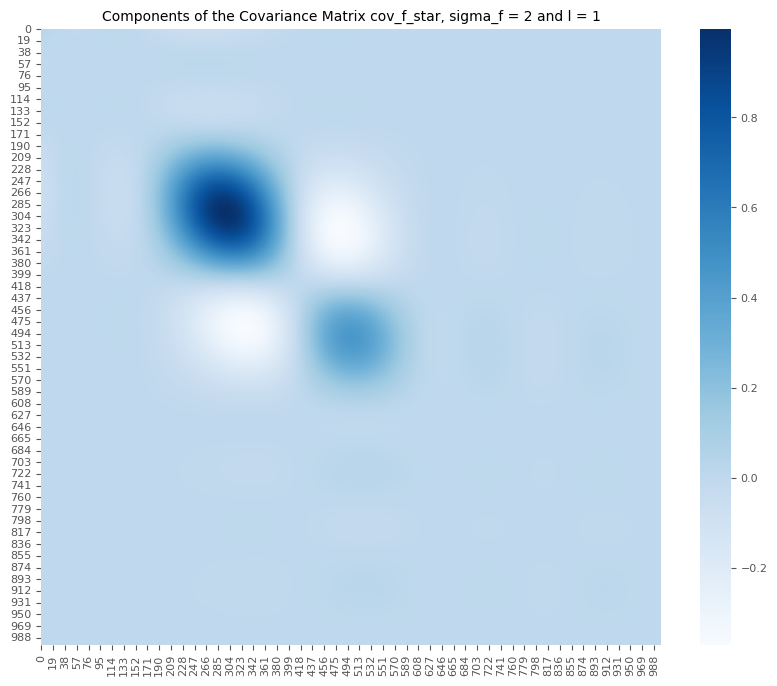

In [46]:
l = 1
sigma_f = 2

# Compute covariance matrices. 
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=False)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
plt.title(f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

In this case the values of the posterior covariance matrix are not that localized. This means that we expect points far away can still have some interaction, i.e. the fit becomes more global. Let us plot the resulting fit:

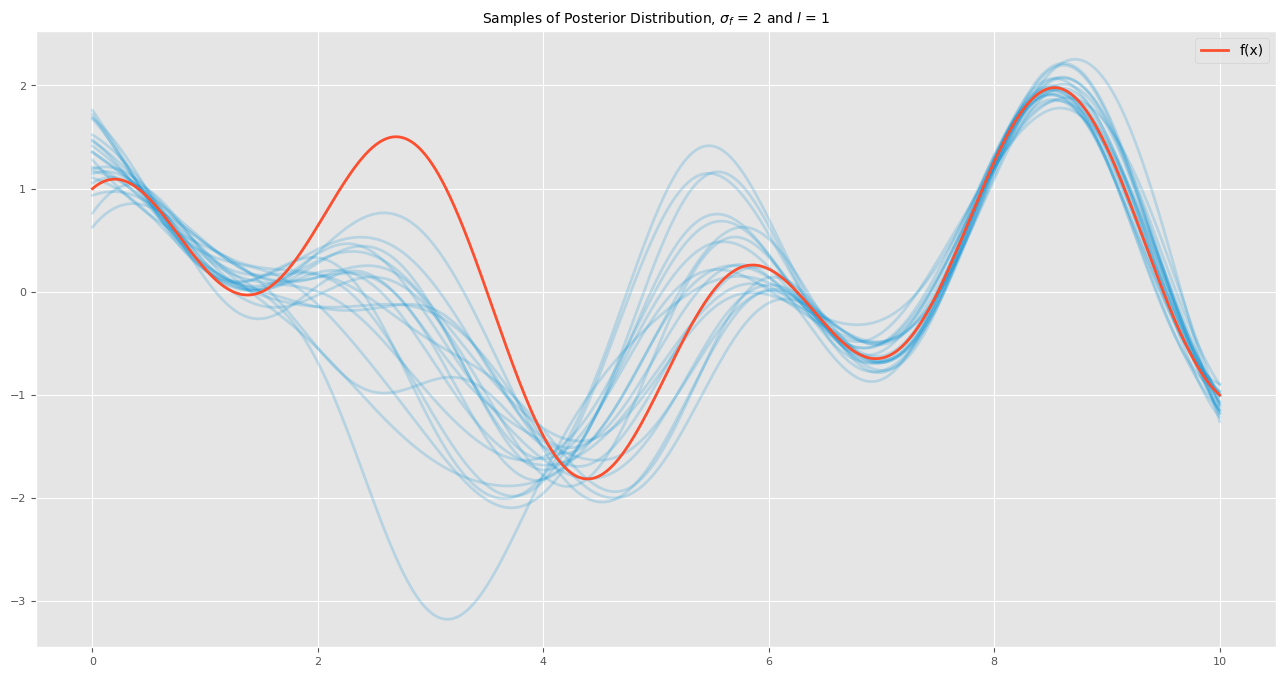

In [47]:
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=True)
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)

fig, ax = plt.subplots()
for i in range(0, 20):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    plt.plot(X, z_star, color=colors[0], alpha=0.2);
plt.plot(X, Y, color=colors[1], label='f(x)')
plt.title(f'Samples of Posterior Distribution, $\sigma_f$ = {sigma_f} and $l$ = {l}')
plt.legend(loc='upper right');

- $\sigma_f = 2$ and $\ell = 0.001$

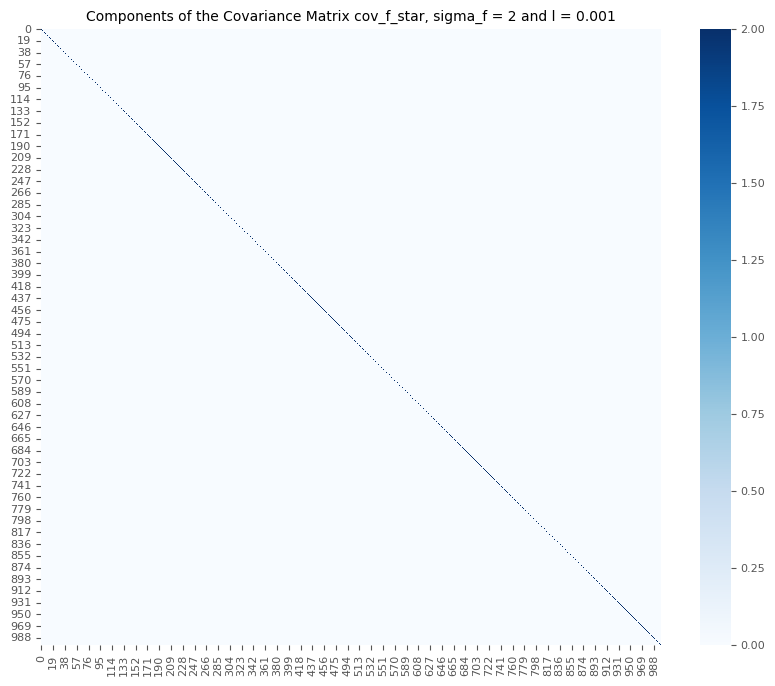

In [48]:
l = 0.001
sigma_f = 2

# Compute covariance matrices. 
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=True)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)
# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
plt.title(f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

In contrast, we see that for these set of hyper parameters the higher values of the posterior covariance matrix are concentrated along the diagonal. This means that we expect points far away to have no effect on each other, i.e. the fit becomes more local. Let us plot the resulting fit:

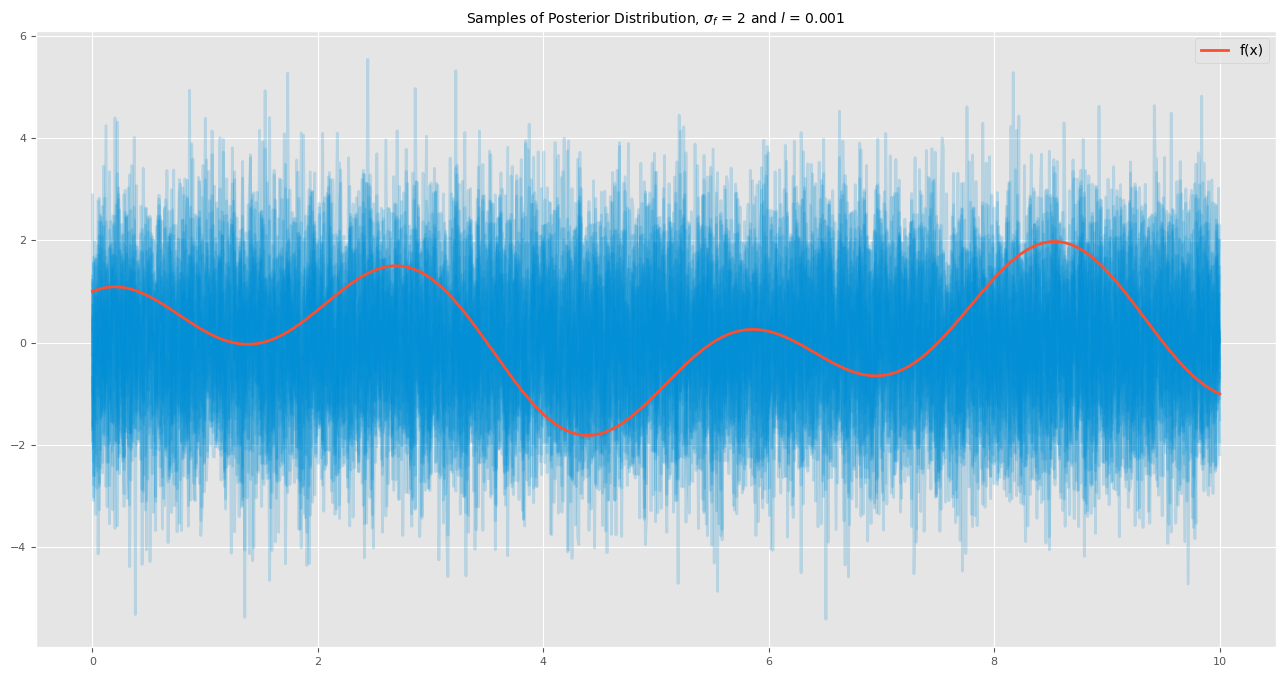

In [49]:
fig, ax = plt.subplots()
for i in range(0, 20):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    plt.plot(X, z_star, color=colors[0], alpha=0.2);
plt.plot(X, Y, color=colors[1], label='f(x)')
plt.title(f'Samples of Posterior Distribution, $\sigma_f$ = {sigma_f} and $l$ = {l}')
plt.legend(loc='upper right');

Hence, we see that the hyperparameter $\ell$ somehow encodes the "complexity" and "locality" of the model. 

- $\sigma_f = 50$ and $\ell = 0.1$

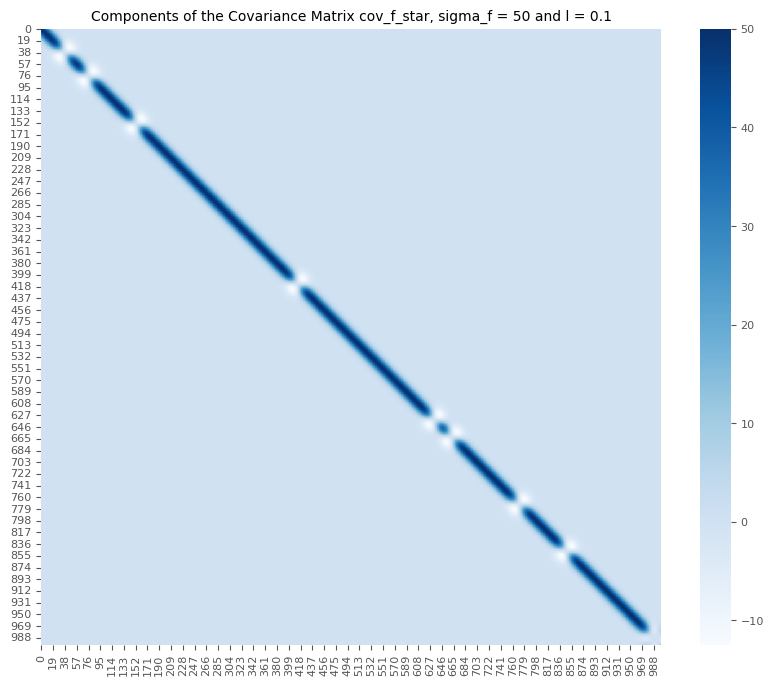

In [50]:
l = 0.1
sigma_f = 50

# Compute covariance matrices. 
C, K, K_star, k_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l, noise=True)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star, k_star, t)
# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
plt.title(f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

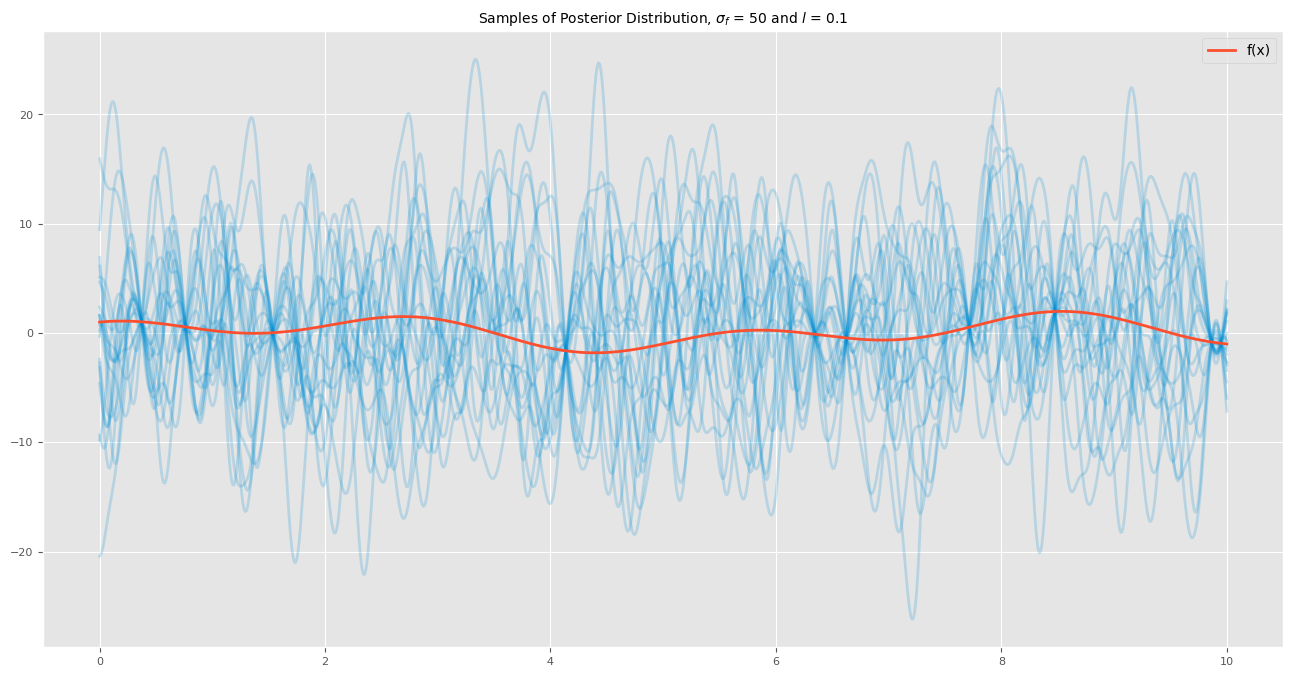

In [51]:
fig, ax = plt.subplots()
for i in range(0, 20):
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    plt.plot(X, z_star, color=colors[0], alpha=0.2);
plt.plot(X, Y, color=colors[1], label='f(x)')
plt.title(f'Samples of Posterior Distribution, $\sigma_f$ = {sigma_f} and $l$ = {l}')
plt.legend(loc='upper right');

The hyperparameter $\sigma_f$ encodes the amplitude of the fit. 

## GaussianProcessRegressor from Scikit-Learn

In [52]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

### Construct Training Set

In [53]:
# Set dimension. 
d = 1
# Number of training points.
n = 1000
# Length of the training set. 
L = 2
# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)
# Error standar deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)
# Generate non-linear function.
def f(x):
    
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x) + np.sin((3*np.pi)*x) 
    
    return(f)

f_x = f(x)

# Observed target variable. 
y = f_x + epsilon

### Construct Test Set

In [54]:
n_star = n + 300
x_star = np.linspace(start=0, stop=(L + 0.5), num=n_star)

X_star = x_star.reshape(n_star, d)

### Define Kernel and Model

In [55]:
# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )

### Model Fit + Predictions

In [56]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)
# Make the prediction on test set.
y_pred = gp.predict(X_star)

In [57]:
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

### Visualize Results

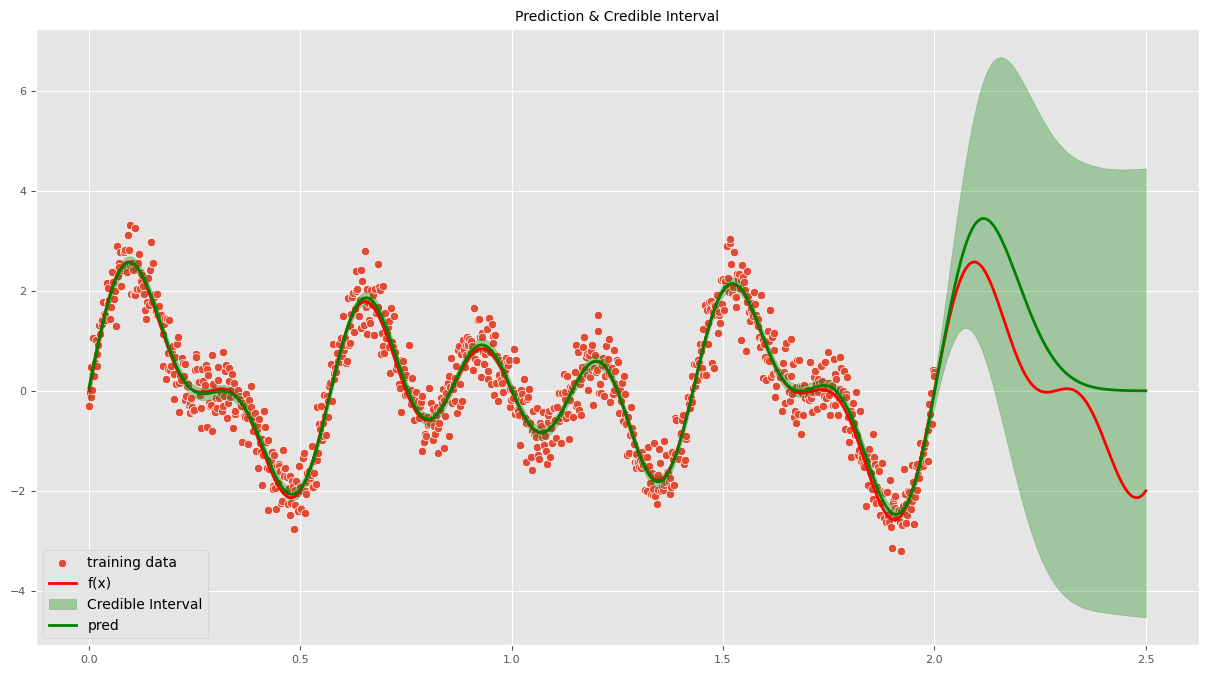

In [59]:
fig, ax = plt.subplots(figsize=(15, 8))

# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);

# Plot "true" linear fit.
sns.lineplot(
    x=x_star, 
    y=f(x_star), 
    color='red', 
    label='f(x)', 
    ax=ax
)

# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green',
    alpha=0.3, 
    label='Credible Interval'
)

# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred')
ax.set(title='Prediction & Credible Interval')
ax.legend(loc='lower left');